In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch import nn
from torch import optim
from torchvision import utils
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

os.chdir("pytorch-CycleGAN-and-pix2pix/") # 다운받은 github 폴더로 이동합니다

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 1. Pix2Pix 구현하기

```
💡 Pix2Pix의 구조 및 손실 함수에 대해 알아보고, 직접 구현해봅니다.
```

[Pix2Pix](https://arxiv.org/pdf/1611.07004.pdf) 모델은 조건부 GAN 모델으로 조건부로 입력 클래스의 이미지($x$)를 입력 받아 잠재 벡터($z$)로부터 출력 클래스의 이미지($y$)를 생성하도록 고안되었습니다. 추가적으로 조건부 GAN 손실 함수에 L1 패널티(=성분 별 차이의 절댓값의 합)
$$
\mathbb{E}_{x,y,z}[\|y - G(x,z)\|_1]
$$
함수를 사용하면 더욱 선명한 이미지를 생성할 수 있습니다. 전체적인 손실 함수는 다음과 같게 됩니다. $\lambda$는 하이퍼파라미터로 변환 이미지의 품질을 조절합니다.
$$
    \min_{G}\max_{D} \big[ \mathbb{E}_{x, y}[\log D(x,y)] + \mathbb{E}_{x,z}[\log D(x, G(x,z))] + \lambda \mathbb{E}_{x,y,z}[\|y - G(x,z)\|_1] \big]
$$
손실 함수에서 볼 수 있듯이 변환하고 싶은 두 클래스의 이미지 쌍(pair) $(x,y)$가 존재할 때 학습이 가능하다는 한계가 있습니다.

### 1-1 데이터셋 준비하기

> CMP Facade 데이터를 다운받고 데이터 로더를 정의합니다.

CycleGAN 공식 코드에서 데이터를 [https://efrosgans.eecs.berkeley.edu/](https://efrosgans.eecs.berkeley.edu/) 링크에서 다운받는 코드를 구현해놓았습니다. 아래 셀을 실행하면 CMP Facade 데이터를 다운받을 수 있습니다.


In [ ]:
# 데이터셋을 다운받습니다.
!bash ./datasets/download_pix2pix_dataset.sh facades

Specified [facades]
for details.

--2023-11-22 14:47:05--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘./datasets/facades.tar.gz’

./datasets/facades. 100%[===================>]  28.77M   598KB/s    in 62s     

2023-11-22 14:48:08 (475 KB/s) - ‘./datasets/facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16

In [ ]:
img = Image.open("datasets/facades/train/1.jpg")
print(img.size)
plt.axis('off')
plt.imshow(img)

In [ ]:
# 데이터셋 폴더에서 이미지 리스트를 불러오는 함수
def make_dataset(dir):
    images = [] # 이미지를 저장할 리스트

    # 폴더에서 파일 이름들을 읽어 이미지 경로를 리스트로 저장합니다
    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            path = os.path.join(root, fname)
            images.append(path)
    return images

In [ ]:
class AlignedDataset(Dataset):
    """
    dir: path to dataset
    phase: train | val | test
    """
    def __init__(self, dir, phase):
        self.dir_AB = os.path.join(dir, phase)
        self.AB_paths = sorted(make_dataset(self.dir_AB))
        self.phase = phase

    def __getitem__(self, index):
        """
        Return a dictionary that contains A, B, A_paths and B_paths
            A (tensor) - - an image in the input domain
            B (tensor) - - its corresponding image in the target domain
            A_paths (str) - - image paths
            B_paths (str) - - image paths (same as A_paths)
        """
        # 해당 index의 이미지를 불러옴
        AB_path = self.AB_paths[index]
        AB = Image.open(AB_path).convert('RGB')
        # 붙어있는 AB 이미지를 A와 B로 나눔
        w, h = AB.size
        w2 = int(w / 2)
        A = AB.crop((0, 0, w2, h)) # (0,0) - (w2,h) 직사각형 영역을 자름 (실제 이미지)
        B = AB.crop((w2, 0, w, h)) # (w2,0) - (w,h) 직사각형 영역을 자름 (레이블 이미지)

        # transform:
        #     학습: 랜덤으로 가로 방향으로 뒤집음 & [-1, 1] 범위의 tensor로 변환
        #     테스트: [-1, 1] 범위의 tensor로 변환
        transform_list = []
        if self.phase == "train":
            transform_list.append(transforms.RandomHorizontalFlip())
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        A_transform = transforms.Compose(transform_list)
        B_transform = transforms.Compose(transform_list)

        A = A_transform(A)
        B = B_transform(B)

        return {'A': A, 'B': B, 'A_paths': AB_path, 'B_paths': AB_path}

    def __len__(self):
        return len(self.AB_paths)

In [ ]:
train_dataset = AlignedDataset("./datasets/facades/", phase="train")
test_dataset = AlignedDataset("./datasets/facades/", phase="test")

# 학습 데이터 수 / 테스트 데이터 수 / A 이미지 크기 출력
len(train_dataset), len(test_dataset), train_dataset[0]["A"].size()

(400, 106, torch.Size([3, 256, 256]))

In [ ]:
# dataloader를 정의해줍니다. 배치 사이즈는 1로 둡니다.
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 1-2. Pix2Pix 모델 클래스 구현

> Pix2Pix 모델 구조를 이해하고 직접 구현해봅니다.

Pix2Pix 모델의 생성자는 변환 전 클래스의 이미지와 잠재 벡터를 입력으로 받아 변환하려는 클래스의 이미지를 생성합니다. **직접적인 구현에서는 표준정규분포를 따르는 잠재 벡터를 따로 입력받지 않고 생성자 구조에서 Dropout 레이어를 활용합니다.** 생성자는 [U-Net](https://arxiv.org/abs/1505.04597) 구조를 활용하였습니다. U-net은 이미지 세그멘테이션(Segmentation)에 활용되는 네트워크로 이미지 크기를 줄여가며 이미지 내의 객체 정보를 얻고 다시 이미지 크기를 늘려가며 객체들의 위치를 파악하는 구조를 가집니다.

판별자는 70 x 70 PatchGAN 모델을 사용합니다. 70 x 70 크기의 이미지 패치를 여러 개 만들고, 각 패치가 실제 이미지인지 생성된 이미지인지 판단합니다.

구조는 CycleGAN 공식 코드로부터 가져옵니다. (`models/networks.py` - *define_G*, *define_D*, *Unetgenerator* 함수 참고) 아래는 `Pix2PixModel` 모델의 내장 함수에 대한 간략한 설명입니다.

* set_input(input): 배치를 불러와서 입력 클래스의 이미지(real_A), 출력 클래스의 이미지(real_B)를 저장합니다.
* forward(): 출력 클래스의 생성 이미지(fake_B)를 저장합니다.
* eval(): 생성자와 판별자를 검증 모드로 변환합니다.
* optimize_parameters(): 손실 함수를 계산하여 판별자와 생성자를 업데이트합니다.
* update_learning_rate(): 매 에폭마다 학습률을 갱신한다.

In [ ]:
class Pix2PixModel(nn.Module):
    def __init__(self, direction, lr, n_epochs, n_epochs_decay, device, beta1=.5, lambda_L1=100.):
        super().__init__() # nn.Module.__init__ 함수를 호출합니다.

        self.loss_names = ["G_GAN", "G_L1", "D_real", "D_fake"]
        self.visual_names = ["real_A", "fake_B", "real_B"]
        self.device = device
        self.direction = direction # AtoB or BtoA
        self.lambda_L1 = lambda_L1 # L1 손실 함수에 대한 패널티 계수
        self.model_names = ["G", "D"]

        # 생성자 정의
        self.netG = networks.define_G(
            input_nc=3, # the number of channels in input images
            output_nc=3, # the number of channels in output images
            ngf=64, # the number of filters in the last conv layer
            netG="unet_256", # U-net structures for 256x256 images
            norm='batch', # the name of normalization layers used in the network: batch | instance | none
            use_dropout=True, # if use dropout layers
            init_type='normal', # the name of our initialization method. (normal, xavier, orthogonal, etc.)
            init_gain=0.02, # scaling factor for normal, xavier and orthogonal
        )

        # 판별자 정의
        self.netD = networks.define_D(
            input_nc=6, # the number of channels in input images
            ndf=64, # the number of filters in the first conv layer
            netD="basic", # the architecture's name: basic | n_layers | pixel
            norm='batch',
            init_type='normal',
            init_gain=0.02
        )

        # Adam 최적화기 정의
        self.optimizer_G = optim.Adam(self.netG.parameters(), lr=lr, betas=(beta1, .999))
        self.optimizer_D = optim.Adam(self.netD.parameters(), lr=lr, betas=(beta1, .999))

        # 학습률 스케줄러 정의 (학습률을 n_epochs 에폭까지는 처음 학습률(=lr)로 유지, 이후 n_epochs_decay 에폭동안 선형으로 감소)
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + 1 - n_epochs) / float(n_epochs_decay + 1)
            return lr_l
        self.scheduler_G = optim.lr_scheduler.LambdaLR(self.optimizer_G, lr_lambda=lambda_rule)
        self.scheduler_D = optim.lr_scheduler.LambdaLR(self.optimizer_D, lr_lambda=lambda_rule)

        # 크로스 엔트로피, L1 패널티 함수 정의
        self.bce = nn.BCEWithLogitsLoss()
        self.criterionL1 = nn.L1Loss()

    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): include the data itself and its metadata information.

        The option 'direction' can be used to swap images in domain A and domain B.
        """
        AtoB = self.direction == 'AtoB'
        self.real_A = input['A' if AtoB else 'B'].to(self.device)
        self.real_B = input['B' if AtoB else 'A'].to(self.device)
        self.image_paths = input['A_paths' if AtoB else 'B_paths']

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.fake_B = self.netG(self.real_A)  # G(A)

    def eval(self):
        """Make models eval mode during test time"""
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                net.eval()

    def optimize_parameters(self):
        self.forward() # G(A) 계산

        # 판별자 업데이트
        self.optimizer_D.zero_grad()
        fake_AB = torch.cat([self.real_A, self.fake_B], dim=1) # 이미지 A, B를 채널 방향으로 붙임 -> 크기 (1, 6, 256, 256)
        pred_fake = self.netD(fake_AB.detach()) # D(A, B) 계산, detach 함수 -> 생성자는 업데이트되지 않음
        self.loss_D_fake = self.bce(pred_fake, torch.zeros_like(pred_fake)) # log (1 - D(A, G(A,z))) 계산

        real_AB = torch.cat([self.real_A, self.real_B], dim=1)
        pred_real = self.netD(real_AB)
        self.loss_D_real = self.bce(pred_real, torch.ones_like(pred_real)) # log D(A, B) 계산

        # 0.5 곱하기: 판별자의 학습 속도를 생성자와 맞추기 위해서 (CycleGAN 논문 Appendix 7.1 참고)
        loss_D = 0.5 * (self.loss_D_real + self.loss_D_fake)
        loss_D.backward()
        self.optimizer_D.step()

        # 생성자 업데이트
        self.optimizer_G.zero_grad()
        pred_fake = self.netD(fake_AB) # D(A, G(A, z))
        self.loss_G_GAN = self.bce(pred_fake, torch.ones_like(pred_fake)) # log D(A, G(A,z))
        self.loss_G_L1 = self.lambda_L1 * self.criterionL1(self.fake_B, self.real_B) # L1 패널티
        loss_G = self.loss_G_GAN + self.loss_G_L1
        loss_G.backward()
        self.optimizer_G.step()

    def update_learning_rate(self):
        self.scheduler_D.step() # 판별자 학습률 업데이트
        self.scheduler_G.step() # 생성자 학습률 업데이트

### 1-3. 학습 과정 구현하기

> Pix2Pix의 학습 과정을 구현하고 학습 결과를 저장해봅니다.

DCGAN과 유사한 하이퍼파라미터를 사용하여 학습합니다. CycleGAN의 공식 코드에서는 처음 100 에폭은 초기 학습률로, 이후 100 에폭은 학습률을 감소시키며 학습을 진행합니다. 본 실습에서는 각 에폭을 절반씩 줄여 50 에폭씩 실험해봅니다. 학습은 2시간 정도 소요됩니다.

In [ ]:
# 학습 파라미터 설정
direction = "BtoA"
lr = 0.0002
n_epochs = 50 # 100 - 공식 코드에서 설정한 값
n_epochs_decay = 50 # 100 - 공식 코드에서 설정한 값
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = Pix2PixModel(direction=direction, lr=lr, n_epochs=n_epochs, n_epochs_decay=n_epochs_decay, device=device).to(device)

initialize network with normal
initialize network with normal


In [ ]:
display_freq = 400 # 400 iteration 마다 loss 출력
# model = torch.compile(model) # pytorch 2.0: 학습속도 개선

total_iters = 0 # 학습 전체 iteration 수
for epoch in range(1, n_epochs + n_epochs_decay + 1):
    epoch_iters = 0 # epoch 단위 iteration 수

    model.update_learning_rate() # 매 에폭마다 학습률 갱신
    # train
    for i, data in enumerate(train_loader):
        total_iters += data["A"].size(0) # 배치 사이즈만큼 iteration 누적
        epoch_iters += data["A"].size(0) # 배치 사이즈만큼 iteration 누적

        model.set_input(data) # real_A, fake_B, real_B 정의
        model.optimize_parameters() # 판별자, 생성자 학습

        if total_iters % display_freq == 0:
            print_str = f"[{total_iters} iters] "
            for name in model.loss_names:
                print_str += f"{name}: {float(getattr(model, 'loss_' + name)):.6f}\t"
            print(print_str)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[400 iters] G_GAN: 2.178515	G_L1: 38.541855	D_real: 0.020214	D_fake: 0.078369	
[800 iters] G_GAN: 2.689428	G_L1: 30.670429	D_real: 0.198977	D_fake: 0.149933	
[1200 iters] G_GAN: 2.846998	G_L1: 36.297344	D_real: 1.274988	D_fake: 0.021420	
[1600 iters] G_GAN: 3.471089	G_L1: 48.826332	D_real: 0.008571	D_fake: 0.054904	
[2000 iters] G_GAN: 2.784053	G_L1: 42.735218	D_real: 0.005903	D_fake: 0.200564	
[2400 iters] G_GAN: 1.868907	G_L1: 31.580379	D_real: 0.255315	D_fake: 0.079672	
[2800 iters] G_GAN: 2.756357	G_L1: 43.130882	D_real: 0.011826	D_fake: 0.130615	
[3200 iters] G_GAN: 0.709884	G_L1: 28.048658	D_real: 0.819242	D_fake: 0.661184	
[3600 iters] G_GAN: 2.776386	G_L1: 31.506275	D_real: 0.666566	D_fake: 0.039505	
[4000 iters] G_GAN: 1.869305	G_L1: 28.660818	D_real: 0.834657	D_fake: 0.116218	
[4400 iters] G_GAN: 2.502509	G_L1: 34.111961	D_real: 1.782951	D_fake: 0.020948	
[4800 iters] G_GAN: 2.233804	G_L1: 28.981007	D_real: 0.084683	D_fake: 0.380685	
[5200 iters] G_GAN: 1.528949	G_L1: 37.4248

In [ ]:
# checkpoints 폴더에 모델 가중치 저장합니다
os.mkdir("checkpoints")
for name in model.model_names:
    net = getattr(model, "net" + name)
    torch.save(net.state_dict(), f"checkpoints/last_net_{name}.pth")

In [ ]:
# 저장된 모델 확인
!ls checkpoints/

last_net_D.pth	last_net_G.pth


### 1-4. 조건부 생성 이미지 살펴보기

> 학습한 모델 가중치를 불러오고 조건부 생성 이미지를 확인해봅니다.

In [ ]:
# 저장된 가중치를 불러옵니다
model = Pix2PixModel(direction=direction, lr=lr, n_epochs=n_epochs, n_epochs_decay=n_epochs_decay, device=device).to(device)

for name in model.model_names:
    net = getattr(model, "net" + name)
    net.load_state_dict(torch.load(f"checkpoints/last_net_{name}.pth"))

initialize network with normal
initialize network with normal


In [ ]:
imgpath = "results/pix2pix"
os.makedirs(imgpath, exist_ok=True) # 결과 저장할 폴더 만들기
model.eval() # 평가 모드로 변환

num_test = 50 # 살펴볼 생성 이미지의 개수

# 조건부 이미지 생성
for i, data in enumerate(test_loader):
    if i >= num_test:
        break
    model.set_input(data)

    with torch.no_grad():
        model.forward() # 변환 이미지(fake_B) 계산

    # 이미지 저장 (픽셀값 범위를 [-1,1]에서 [0,1]로 변환)
    utils.save_image((model.real_A.cpu()+1.)*0.5, f"{imgpath}/{i+1}_real_A.png")
    utils.save_image((model.real_B.cpu()+1.)*0.5, f"{imgpath}/{i+1}_real_B.png")
    utils.save_image((model.fake_B.cpu()+1.)*0.5, f"{imgpath}/{i+1}_fake_B.png")

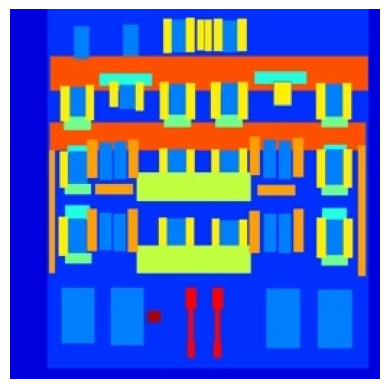

In [ ]:
img_real_A = Image.open("results/pix2pix/30_real_A.png")
plt.axis('off')
plt.imshow(img_real_A)

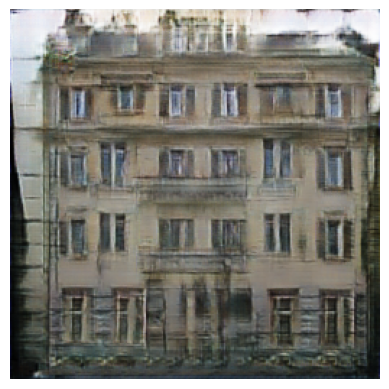

In [ ]:
img_fake_B = Image.open("results/pix2pix/30_fake_B.png")
plt.axis('off')
plt.imshow(img_fake_B)

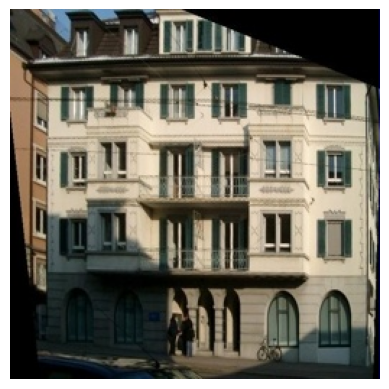

In [ ]:
img_real_B = Image.open("results/pix2pix/30_real_B.png")
plt.axis('off')
plt.imshow(img_real_B)

CycleGAN 공식 코드에서 제공하는 사전 훈련된 가중치를 불러와서 생성해볼 수 있습니다.

In [ ]:
# 사전 훈련된 가중치 다운로드
!bash ./scripts/download_pix2pix_model.sh facades_label2photo

Note: available models are edges2shoes, sat2map, map2sat, facades_label2photo, and day2night
Specified [facades_label2photo]
for details.

--2023-11-22 16:20:48--  http://efrosgans.eecs.berkeley.edu/pix2pix/models-pytorch/facades_label2photo.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217704720 (208M)
Saving to: ‘./checkpoints/facades_label2photo_pretrained/latest_net_G.pth’

./checkpoints/facad 100%[===================>] 207.62M  19.8MB/s    in 11s     

2023-11-22 16:20:59 (18.8 MB/s) - ‘./checkpoints/facades_label2photo_pretrained/latest_net_G.pth’ saved [217704720/217704720]



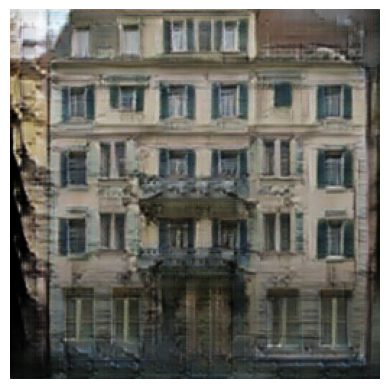

In [ ]:
model.netG.load_state_dict(torch.load("checkpoints/facades_label2photo_pretrained/latest_net_G.pth"))

data = test_dataset[29] # 위에서 그렸던 30번째 이미지
data.update({"A": test_dataset[29]["A"].unsqueeze(0), "B": test_dataset[29]["B"].unsqueeze(0)})

# 변환 이미지(fake_B) 계산
with torch.no_grad():
    model.set_input(data)
    model.forward()

# 이미지 출력:
#     1. cpu(): 먼저 tensor를 gpu -> cpu로 전달
#     2. squeeze(): 1 x 3 x 256 x 256 -> 3 x 256 x 256 크기로 줄임
#     3. permute(1,2,0): C x H x W -> H x W x C 로 변환 (= matplotlib에서 입력값의 차원 순서)
#     4. (x+1.0)*0.5: [-1, 1] 범위의 픽셀을 [0, 1] 범위로 변환
plt.axis("off")
plt.imshow((model.fake_B.cpu().squeeze().permute(1,2,0)+1.0)*0.5)

## 2. CycleGAN 구현하기

```
💡 CycleGAN의 구조 및 손실 함수에 대해 알아보고, 직접 구현해봅니다.
```

CycleGAN은 Pix2Pix와 달리 2개 클래스의 이미지가 쌍이 지어지지 않았더라도 이미지 변환을 수행할 수 있는 모델입니다. 2개 클래스의 사진만 따로 모아져 있다면 CycleGAN을 이용해 이미지 변환을 수행할 수 있습니다. 쌍이 지어지지 않은 데이터를 처리하기 위해 기존 입력 클래스($X$)에서 출력 클래스($Y$)로 변환해주는 생성자($G: X \rightarrow Y$)와 더불어 출력 클래스($Y$)에서 입력 클래스($X$)로 변환해주는 **새로운 생성자**($F:Y \rightarrow X$)를 정의합니다. 각 클래스별로 판별자가 존재해서 **입력 클래스의 판별자**($D_X$)는 $F(y)$와 $x$를 구분하고, **출력 클래스의 판별자**($D_Y$)는 $G(x)$와 $y$를 구분합니다. 각각의 판별자와 생성자의 학습을 위해 GAN의 손실 함수를 사용하게 됩니다.
* 입력 클래스($X$)의 손실 함수: $\mathbb{L}_{GAN}(F, D_X, Y, X) = \mathbb{E}_{x \sim p_{data}(x)}[\log D_X(x)] + \mathbb{E}_{y \sim p_{data}(y)}[\log (1 - D_X(F(y))]$
* 출력 클래스($Y$)의 손실 함수: $\mathbb{L}_{GAN}(G, D_Y, X, Y) = \mathbb{E}_{y \sim p_{data}(y)}[\log D_Y(y)] + \mathbb{E}_{x \sim p_{data}(x)}[\log (1 - D_Y(G(x))]$

각 판별자를 잘 속이도록 2개의 생성자가 학습이 된다면 판별자를 속이기만 하면 되므로 정확한 이미지 변환 학습이 되지 않게 됩니다. 예를 들어, 말 사진을 얼룩말 사진으로 바꾼다고 할 때, 말 사진에서 말의 무늬만 얼룩말처럼 바꾸는 것이 우리의 목표지만 판별자를 속이기 위해서는 임의의 얼룩말 사진만 생성해도 충분합니다. 따라서, 이를 개선하기 위해 2가지 손실 함수를 추가로 고려합니다.
* 순전(Forward) Cycle 일치성(Consistency) 손실 함수: $\mathbb{E}_{x \sim p_{data}(x)}[\| F(G(x)) - x \|_1]$
* 역전(Backward) Cycle 일치성(Consistency) 손실 함수: $\mathbb{E}_{x \sim p_{data}(x)}[\| G(F(y)) - y \|_1]$

### 2-1. 데이터셋 준비하기

> CMP Facade 데이터셋을 다운받고 Pix2Pix와의 데이터 구조 차이를 살펴봅니다.

CMP Facade 데이터는 쌍이 지어져 있지만 CycleGAN 학습에는 따로 분리하여 진행합니다. 아래 코드로 데이터를 다운받으면 Pix2Pix와 다르게 `trainA`와 `trainB` 폴더로 입력 클래스와 출력 클래스의 이미지가 다른 폴더에 위치합니다.

In [ ]:
!bash ./datasets/download_cyclegan_dataset.sh facades

Specified [facades]
for details.

--2023-11-22 19:20:14--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/facades.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35135868 (34M) [application/zip]
Saving to: ‘./datasets/facades.zip’

./datasets/facades. 100%[===================>]  33.51M  1.51MB/s    in 23s     

2023-11-22 19:20:37 (1.45 MB/s) - ‘./datasets/facades.zip’ saved [35135868/35135868]

Archive:  ./datasets/facades.zip
   creating: ./datasets/facades/trainA/
  inflating: ./datasets/facades/trainA/110_A.jpg  
  inflating: ./datasets/facades/trainA/324_A.jpg  
  inflating: ./datasets/facades/trainA/353_A.jpg  
  inflating: ./datasets/facades/trainA/319_A.jpg  
  inflating: ./datasets/facades/trainA/20_A.jpg  
  inflating: ./datasets/facades/trainA/274_A.jpg  
  inflating: ./

(256, 256) (256, 256)


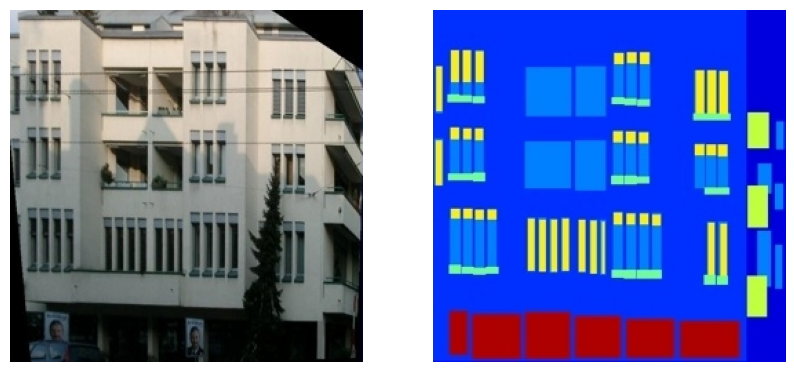

In [ ]:
imgA = Image.open("datasets/facades/trainA/1_A.jpg")
imgB = Image.open("datasets/facades/trainB/1_B.jpg")
print(imgA.size, imgB.size)

plt.figure(figsize=(10, 5)) # 그림 크기(가로, 세로)를 조절합니다.
plt.subplot(121) # 1행 2열 중 1번 그림
plt.axis('off')
plt.imshow(imgA)
plt.subplot(122) # 1행 2열 중 2번 그림
plt.axis('off')
plt.imshow(imgB)
plt.show()

In [ ]:
import random

In [ ]:
class UnalignedDataset(Dataset):
    """
    dir: path to dataset
    phase: train | val | test
    """
    def __init__(self, dir, phase):
        self.dir_A = os.path.join(dir, phase+"A") # create a path '/path/to/data/trainA'
        self.dir_B = os.path.join(dir, phase+"B") # create a path '/path/to/data/trainA'

        self.A_paths = sorted(make_dataset(self.dir_A)) # load images from '/path/to/data/trainA'
        self.B_paths = sorted(make_dataset(self.dir_B)) # load images from '/path/to/data/trainA'
        self.A_size = len(self.A_paths) # get the size of dataset A
        self.B_size = len(self.B_paths) # get the size of dataset B

        self.phase = phase

    def __getitem__(self, index):
        """
        Return a dictionary that contains A, B, A_paths and B_paths
            A (tensor) - - an image in the input domain
            B (tensor) - - its corresponding image in the target domain
            A_paths (str) - - image paths
            B_paths (str) - - image paths (same as A_paths)
        """
        # 해당 index의 이미지를 불러옴
        A_path = self.A_paths[index % self.A_size] # index가 A 클래스 이미지 개수보다 작도록 나머지 계산
        if self.phase == "test":
            # test일 때는 고정된 (A, B) 쌍으로 데이터셋 구성
            index_B = index % self.B_size
        else:
            # train일 때는 B 클래스에서 임의의 이미지를 추출
            index_B = random.randint(0, self.B_size - 1)
        B_path = self.B_paths[index_B]

        # 이미지 불러오기
        A_img = Image.open(A_path).convert('RGB')
        B_img = Image.open(B_path).convert('RGB')

        # transform:
        #     학습: 랜덤으로 가로 방향으로 뒤집음 & [-1, 1] 범위의 tensor로 변환
        #     테스트: [-1, 1] 범위의 tensor로 변환
        transform_list = []
        if self.phase == "train":
            transform_list.append(transforms.RandomHorizontalFlip())
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        A_transform = transforms.Compose(transform_list)
        B_transform = transforms.Compose(transform_list)

        A = A_transform(A_img)
        B = B_transform(B_img)

        return {'A': A, 'B': B, 'A_paths': A_path, 'B_paths': B_path}

    def __len__(self):
        return max(self.A_size, self.B_size)

In [ ]:
cyclegan_train_dataset = UnalignedDataset("./datasets/facades/", phase="train")
cyclegan_test_dataset = UnalignedDataset("./datasets/facades/", phase="test")

# 학습 데이터 수 / 테스트 데이터 수 / A 이미지 크기 출력
len(cyclegan_train_dataset), len(cyclegan_test_dataset), cyclegan_train_dataset[0]["A"].size()

(400, 106, torch.Size([3, 256, 256]))

In [ ]:
# dataloader를 정의해줍니다. 배치 사이즈는 1로 둡니다.
cyclegan_train_loader = DataLoader(cyclegan_train_dataset, batch_size=1, shuffle=True)
cyclegan_test_loader = DataLoader(cyclegan_test_dataset, batch_size=1, shuffle=False)

### 2-2. CycleGAN 모델 클래스 구현

> 구체적으로 CycleGAN의 구조 및 손실 함수를 살펴보고 직접 구현해봅니다.

CycleGAN 모델의 생성자는 이미지를 입력으로 받아 변환된 이미지를 출력합니다. 구조는 3개의 합성곱 신경망, 여러 개의 Residual block, 2개의 전치 합성곱 신경망, 출력 채널 수를 맞추기 위한 합성곱 신경망 순서대로 구성됩니다.
$$
\begin{aligned}
& \text{3 conv layers} \rightarrow \text{residual blocks} \\
& \rightarrow \text{2 transpose conv layers} \rightarrow \text{conv layer}
\end{aligned}
$$

각 레이어마다 Instance 정규화와 ReLU 활성화 함수를 적용합니다. Instance 정규화는 각 데이터, 채널마다 정규화를 진행하여 각 데이터의 개별적인 특징을 유지할 수 있습니다.

CycleGAN 모델의 판별자도 70 x 70 PatchGAN 모델을 사용합니다. 70 x 70 크기의 이미지 패치를 여러 개 만들고, 각 패치가 실제 이미지인지 생성된 이미지인지 판단합니다. 그리고 판별자를 학습할 때 이전에 생성된 이미지를 활용하는 방식을 사용합니다 ([Shrivastava et al. (2017)](https://arxiv.org/abs/1612.07828) 참고). 50개의 생성 이미지를 `ImagePool` 클래스에 넣어두고, 50개의 생성 이미지 중에 랜덤하게 한 이미지를 뽑아서 판별자 학습에 이용합니다. 이는 판별자가 기존에 학습한 경향을 잊어버리고, 최근 생성 이미지에 맞춰서 학습되는 현상을 방지합니다.


CycleGAN 모델을 학습할 때 GAN 손실 함수 대신 LSGAN(Least-square GAN) 손실 함수를 사용했을 때 품질 좋은 이미지를 얻을 수 있습니다. 판별자는
$$
\mathbb{E}_{y \sim p_{data}(y)}[(D(y) - 1)^2] + \mathbb{E}_{x \sim p_{data}(x)}[D(G(x))^2]
$$
을 최소화하고, 생성자는
$$
\mathbb{E}_{x \sim p_{data}(x)}[(D(G(x)) - 1)^2]
$$
을 최소화하게 됩니다.

각 구조는 CycleGAN 공식 코드로부터 가져옵니다. (`models/networks.py` - *define_G*, *define_D*, *ResnetGenerator* 함수 참고) 아래의 `CycleGANModel` 모델은 Pix2Pix 모델과 비슷한 구조로 정의됩니다.

In [ ]:
from util.image_pool import ImagePool

In [ ]:
class CycleGANModel(nn.Module):
    """
    For CycleGAN, in addition to GAN losses, we introduce lambda_A, lambda_B, and lambda_identity for the following losses.

    A (source domain), B (target domain).
    Generators: G_A: A -> B; G_B: B -> A.
    Discriminators: D_A: G_A(A) vs. B; D_B: G_B(B) vs. A.
    Forward cycle loss:  lambda_A * ||G_B(G_A(A)) - A|| (Eqn. (2) in the paper)
    Backward cycle loss: lambda_B * ||G_A(G_B(B)) - B|| (Eqn. (2) in the paper)
    Dropout is not used in the original CycleGAN paper.
    """
    def __init__(self, direction, lr, n_epochs, n_epochs_decay, device, beta1=.5, lambda_A=10., lambda_B=10.):
        super().__init__() # nn.Module.__init__ 함수를 호출합니다.

        self.loss_names = ['D_A', 'G_A', 'cycle_A', 'D_B', 'G_B', 'cycle_B']
        self.visual_names_A = ["real_A", "fake_B", "rec_A"]
        self.visual_names_B = ["real_B", "fake_A", "rec_B"]
        self.device = device
        self.direction = direction # AtoB or BtoA
        self.lambda_A = lambda_A # A 클래스 cycle 손실 함수에 대한 패널티 계수
        self.lambda_B = lambda_B # B 클래스 cycle 손실 함수에 대한 패널티 계수
        self.visual_names = self.visual_names_A + self.visual_names_B
        self.model_names = ["G_A", "G_B", "D_A", "D_B"]

        # 생성자 정의
        # Code (vs. paper): G_A (G), G_B (F), D_A (D_Y), D_B (D_X)
        self.netG_A = networks.define_G(
            input_nc=3, # the number of channels in input images
            output_nc=3, # the number of channels in output images
            ngf=64, # the number of filters in the last conv layer
            netG="resnet_9blocks", # resnet structures for 256x256 images
            norm='instance', # the name of normalization layers used in the network: batch | instance | none
            use_dropout=False, # if use dropout layers
            init_type='normal', # the name of our initialization method. (normal, xavier, orthogonal, etc.)
            init_gain=0.02, # scaling factor for normal, xavier and orthogonal
        )

        self.netG_B = networks.define_G(
            input_nc=3, # the number of channels in input images
            output_nc=3, # the number of channels in output images
            ngf=64, # the number of filters in the last conv layer
            netG="resnet_9blocks", # resnet structures for 256x256 images
            norm='instance', # the name of normalization layers used in the network: batch | instance | none
            use_dropout=False, # if use dropout layers
            init_type='normal', # the name of our initialization method. (normal, xavier, orthogonal, etc.)
            init_gain=0.02, # scaling factor for normal, xavier and orthogonal
        )

        # 판별자 정의
        self.netD_A = networks.define_D(
            input_nc=3, # the number of channels in input images
            ndf=64, # the number of filters in the first conv layer
            netD="basic", # the architecture's name: basic (PatchGAN) | n_layers | pixel
            norm='instance',
            init_type='normal',
            init_gain=0.02
        )

        self.netD_B = networks.define_D(
            input_nc=3, # the number of channels in input images
            ndf=64, # the number of filters in the first conv layer
            netD="basic", # the architecture's name: basic (PatchGAN) | n_layers | pixel
            norm='instance',
            init_type='normal',
            init_gain=0.02
        )

        # 생성된 이미지 buffer 정의
        self.fake_A_pool = ImagePool(pool_size=50)  # create image buffer to store previously generated images
        self.fake_B_pool = ImagePool(pool_size=50)  # create image buffer to store previously generated images

        # Adam 최적화기 정의
        self.optimizer_G = optim.Adam(list(self.netG_A.parameters()) + list(self.netG_B.parameters()), lr=lr, betas=(beta1, .999))
        self.optimizer_D = optim.Adam(list(self.netD_A.parameters()) + list(self.netD_B.parameters()), lr=lr, betas=(beta1, .999))

        # 학습률 스케줄러 정의 (학습률을 n_epochs 에폭까지는 처음 학습률(=lr)로 유지, 이후 n_epochs_decay 에폭동안 선형으로 감소)
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + 1 - n_epochs) / float(n_epochs_decay + 1)
            return lr_l
        self.scheduler_G = optim.lr_scheduler.LambdaLR(self.optimizer_G, lr_lambda=lambda_rule)
        self.scheduler_D = optim.lr_scheduler.LambdaLR(self.optimizer_D, lr_lambda=lambda_rule)

        # 크로스 엔트로피, L1 패널티 함수 정의
        self.mse = nn.MSELoss()
        self.criterionL1 = nn.L1Loss()

    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): include the data itself and its metadata information.

        The option 'direction' can be used to swap domain A and domain B.
        """
        AtoB = self.direction == 'AtoB'
        self.real_A = input['A' if AtoB else 'B'].to(self.device)
        self.real_B = input['B' if AtoB else 'A'].to(self.device)
        self.image_paths = input['A_paths' if AtoB else 'B_paths']

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.fake_B = self.netG_A(self.real_A)  # G_A(A)
        self.rec_A = self.netG_B(self.fake_B)   # G_B(G_A(A))
        self.fake_A = self.netG_B(self.real_B)  # G_B(B)
        self.rec_B = self.netG_A(self.fake_A)   # G_A(G_B(B))

    def eval(self):
        """Make models eval mode during test time"""
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                net.eval()

    def optimize_parameters(self):
        self.forward() # G(A) 계산

        # 생성자 G_A, G_B 업데이트
        self.optimizer_G.zero_grad()
        # GAN loss D_A(G_A(A))
        pred_fake_B = self.netD_A(self.fake_B)
        self.loss_G_A = self.mse(pred_fake_B, torch.ones_like(pred_fake_B))
        # GAN loss D_B(G_B(B))
        pred_fake_A = self.netD_B(self.fake_A)
        self.loss_G_B = self.mse(pred_fake_A, torch.ones_like(pred_fake_A))
        # Forward cycle loss: || G_B(G_A(A)) - A ||
        self.loss_cycle_A = self.criterionL1(self.rec_A, self.real_A) * self.lambda_A
        # Backward cycle loss: || G_A(G_B(B)) - B ||
        self.loss_cycle_B = self.criterionL1(self.rec_B, self.real_B) * self.lambda_B
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B
        self.loss_G.backward()
        self.optimizer_G.step()

        # 판별자 D_A, D_B 업데이트
        self.optimizer_D.zero_grad()
        fake_B = self.fake_B_pool.query(self.fake_B) # 생성 이미지 50개 목록에서 생성 이미지를 하나 추출
        pred_fake = self.netD_A(fake_B.detach()) # D_A(G_A(A))
        pred_real = self.netD_A(self.real_B) # D_A(B)
        # 0.5 곱하기: 판별자의 학습 속도를 생성자와 맞추기 위해서 (CycleGAN 논문 Appendix 7.1 참고)
        self.loss_D_A = 0.5 * (
            self.mse(pred_real, torch.ones_like(pred_real)) + self.mse(pred_fake, torch.zeros_like(pred_fake))
        )
        self.loss_D_A.backward()

        fake_A = self.fake_A_pool.query(self.fake_A) # 생성 이미지 50개 목록에서 생성 이미지를 하나 추출
        pred_fake = self.netD_B(fake_A.detach()) # D_B(G_B(B))
        pred_real = self.netD_B(self.real_A) # D_B(A)
        # 0.5 곱하기: 판별자의 학습 속도를 생성자와 맞추기 위해서 (CycleGAN 논문 Appendix 7.1 참고)
        self.loss_D_B = 0.5 * (
            self.mse(pred_real, torch.ones_like(pred_real)) + self.mse(pred_fake, torch.zeros_like(pred_fake))
        )
        self.loss_D_B.backward()
        self.optimizer_D.step()

    def update_learning_rate(self):
        self.scheduler_D.step() # 판별자 학습률 업데이트
        self.scheduler_G.step() # 생성자 학습률 업데이트

### 2-3. 학습 과정 구현하기

> 학습 과정을 구현하고 모델을 저장해봅니다.

[DCGAN](https://arxiv.org/abs/1511.06434)과 유사한 하이퍼파라미터를 사용하여 학습합니다. CycleGAN의 공식 코드에서는 처음 100 에폭은 초기 학습률로, 이후 100 에폭은 학습률을 감소시키며 학습을 진행합니다. 본 실습에서는 25 에폭씩만 실험해봅니다. 학습은 3시간 정도 소요됩니다.

In [ ]:
# 학습 파라미터 설정
direction = "BtoA"
lr = 0.0002
n_epochs = 25 # 100 - 공식 코드에서 설정한 값
n_epochs_decay = 25 # 100 - 공식 코드에서 설정한 값
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = CycleGANModel(direction=direction, lr=lr, n_epochs=n_epochs, n_epochs_decay=n_epochs_decay, device=device).to(device)

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal


In [ ]:
display_freq = 400 # 400 iteration 마다 loss 출력
model = torch.compile(model) # pytorch 2.0: 학습속도 개선

total_iters = 0 # 학습 전체 iteration 수
for epoch in range(1, n_epochs + n_epochs_decay + 1):
    epoch_iters = 0 # epoch 단위 iteration 수

    model.update_learning_rate() # 매 에폭마다 학습률 갱신
    # train
    for i, data in enumerate(cyclegan_train_loader):
        total_iters += data["A"].size(0) # 배치 사이즈만큼 iteration 누적
        epoch_iters += data["A"].size(0) # 배치 사이즈만큼 iteration 누적

        model.set_input(data) # real_A, fake_B, real_B 정의
        model.optimize_parameters() # 판별자, 생성자 학습

        if total_iters % display_freq == 0:
            print_str = f"[{total_iters} iters] "
            for name in model.loss_names:
                print_str += f"{name}: {float(getattr(model, 'loss_' + name)):.6f}\t"
            print(print_str)

[400 iters] D_A: 0.337348	G_A: 0.261489	cycle_A: 1.846233	D_B: 0.454935	G_B: 0.421576	cycle_B: 4.662190	
[800 iters] D_A: 0.213860	G_A: 0.651456	cycle_A: 1.620672	D_B: 0.163795	G_B: 0.378304	cycle_B: 2.339344	
[1200 iters] D_A: 0.247432	G_A: 0.385019	cycle_A: 1.787752	D_B: 0.186349	G_B: 0.619513	cycle_B: 1.567564	
[1600 iters] D_A: 0.231635	G_A: 0.388244	cycle_A: 1.192697	D_B: 0.202359	G_B: 0.571773	cycle_B: 2.037248	
[2000 iters] D_A: 0.517353	G_A: 1.271046	cycle_A: 1.317963	D_B: 0.142930	G_B: 0.467303	cycle_B: 2.353314	
[2400 iters] D_A: 0.434958	G_A: 0.075374	cycle_A: 1.129421	D_B: 0.048639	G_B: 0.458784	cycle_B: 1.932135	
[2800 iters] D_A: 0.155659	G_A: 0.448512	cycle_A: 1.105517	D_B: 0.085685	G_B: 0.943708	cycle_B: 2.071307	
[3200 iters] D_A: 0.149134	G_A: 0.722604	cycle_A: 0.898889	D_B: 0.102075	G_B: 0.450487	cycle_B: 1.283934	
[3600 iters] D_A: 0.299221	G_A: 0.133331	cycle_A: 0.893680	D_B: 0.259145	G_B: 1.660812	cycle_B: 1.584834	
[4000 iters] D_A: 0.142116	G_A: 0.404428	cycle_A

In [ ]:
# checkpoints 폴더에 모델 저장
os.makedirs("checkpoints", exist_ok=True)
for name in model.model_names:
    net = getattr(model, "net" + name)
    torch.save(net.state_dict(), f"checkpoints/last_net_{name}.pth")

In [ ]:
# 저장된 모델 확인
!ls checkpoints/

last_net_D_A.pth  last_net_D_B.pth  last_net_G_A.pth  last_net_G_B.pth


### 2-4. 조건부 생성 이미지 살펴보기

> 저장한 모델을 불러오고 이미지 변환 결과를 살펴봅니다.

In [ ]:
# 저장된 가중치를 불러옵니다
model = CycleGANModel(direction=direction, lr=lr, n_epochs=n_epochs, n_epochs_decay=n_epochs_decay, device=device).to(device)

for name in model.model_names:
    net = getattr(model, "net" + name)
    net.load_state_dict(torch.load(f"checkpoints/last_net_{name}.pth"))

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal


In [ ]:
imgpath = "results/cyclegan"
os.makedirs(imgpath, exist_ok=True) # 결과 저장할 폴더 만들기
model.eval() # 평가 모드로 변환

num_test = 50 # 살펴볼 생성 이미지의 개수

# 조건부 이미지 생성
for i, data in enumerate(cyclegan_test_loader):
    if i >= num_test:
        break
    model.set_input(data)

    with torch.no_grad():
        model.forward() # fake_B 계산

    # 이미지 저장 (픽셀값 범위를 [-1,1]에서 [0,1]로 변환)
    for name in model.visual_names:
        img = getattr(model, name)
        utils.save_image((img.cpu()+1.)*0.5, f"{imgpath}/{i+1}_{name}.png")

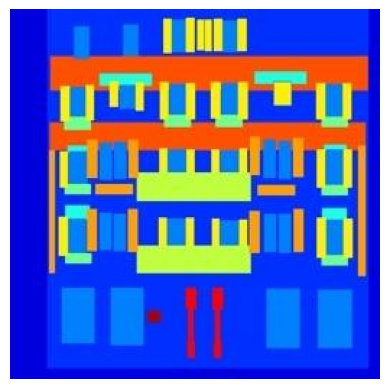

In [ ]:
img_real_A = Image.open("results/cyclegan/30_real_A.png")
plt.axis('off')
plt.imshow(img_real_A)

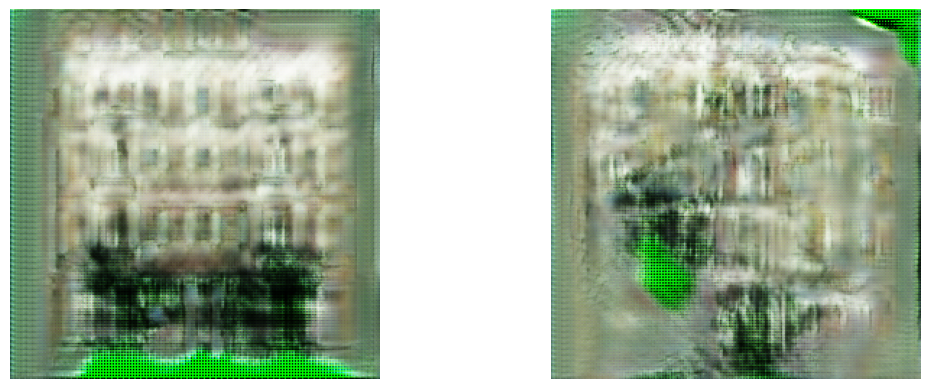

In [ ]:
img_fake_B = Image.open("results/cyclegan/30_fake_B.png")
img_rec_B = Image.open("results/cyclegan/30_rec_B.png")

plt.figure(figsize=(12.8, 4.8))
plt.subplot(121)
plt.axis('off')
plt.imshow(img_fake_B)
plt.subplot(122)
plt.axis('off')
plt.imshow(img_rec_B)

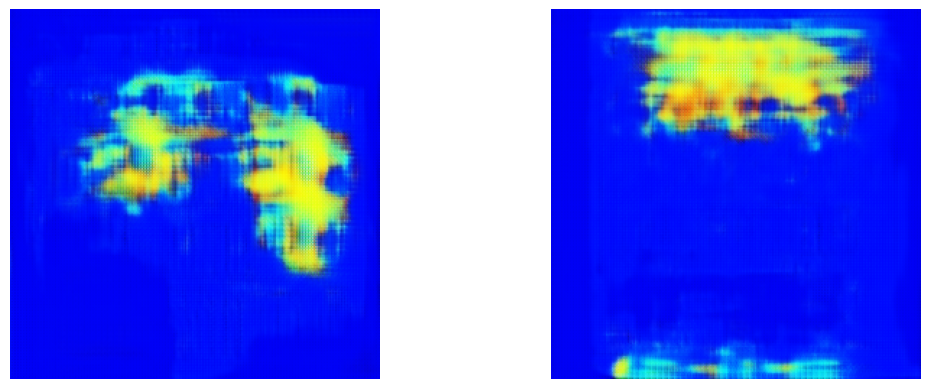

In [ ]:
img_fake_A = Image.open("results/cyclegan/30_fake_A.png")
img_rec_A = Image.open("results/cyclegan/30_rec_A.png")

plt.figure(figsize=(12.8, 4.8))
plt.subplot(121)
plt.axis('off')
plt.imshow(img_fake_A)
plt.subplot(122)
plt.axis('off')
plt.imshow(img_rec_A)

CycleGAN 공식 코드에서 제공하는 사전 훈련된 가중치를 불러와서 생성해볼 수 있습니다. 레이블을 건축물 사진으로 바꿔주는 모형(netG_B)를 불러옵니다.

In [ ]:
# 사전 훈련된 가중치 다운로드
!bash ./scripts/download_cyclegan_model.sh facades_label2photo

Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [facades_label2photo]
for details.

--2023-11-22 22:44:42--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/facades_label2photo.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving to: ‘./checkpoints/facades_label2photo_pretrained/latest_net_G.pth’

./checkpoints/facad 100%[===================>]  43.46M  38.2MB/s    in 1.1s    

2023-11-22 22:44:43 (38.2 MB/s) - ‘./checkpoints/facades_label2photo_pretrained/latest_net_G.pth’ s

In [ ]:
model.netG_B.load_state_dict(torch.load("checkpoints/facades_label2photo_pretrained/latest_net_G.pth"), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['model.2.running_mean', 'model.2.running_var', 'model.2.num_batches_tracked', 'model.5.running_mean', 'model.5.running_var', 'model.5.num_batches_tracked', 'model.8.running_mean', 'model.8.running_var', 'model.8.num_batches_tracked', 'model.10.conv_block.2.running_mean', 'model.10.conv_block.2.running_var', 'model.10.conv_block.2.num_batches_tracked', 'model.10.conv_block.6.running_mean', 'model.10.conv_block.6.running_var', 'model.10.conv_block.6.num_batches_tracked', 'model.11.conv_block.2.running_mean', 'model.11.conv_block.2.running_var', 'model.11.conv_block.2.num_batches_tracked', 'model.11.conv_block.6.running_mean', 'model.11.conv_block.6.running_var', 'model.11.conv_block.6.num_batches_tracked', 'model.12.conv_block.2.running_mean', 'model.12.conv_block.2.running_var', 'model.12.conv_block.2.num_batches_tracked', 'model.12.conv_block.6.running_mean', 'model.12.conv_block.6.running_var', 'model.12.conv_block.6.num_batches_trac

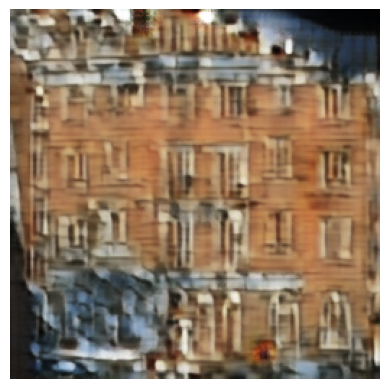

In [ ]:
data = cyclegan_test_dataset[29] # 위에서 그렸던 30번째 이미지
# 이미지 크기를 (3, 256, 256) -> (1, 3, 256, 256)로 변환
data.update({"A": cyclegan_test_dataset[29]["A"].unsqueeze(0), "B": cyclegan_test_dataset[29]["B"].unsqueeze(0)})

with torch.no_grad():
    model.set_input(data)
    fake_A = model.netG_B(model.real_B)

plt.axis("off")
plt.imshow((fake_A.cpu().squeeze().permute(1,2,0)+1.0)*0.5)

#Reference

- [CycleGAN 공식 코드](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
- [CMP facade 데이터셋](https://efrosgans.eecs.berkeley.edu/)